# Librerias

In [3]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [1]:
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier
seed = 42

# Lectura

In [4]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

# Gradient Boosting

In [44]:
param_grid = {
    "n_estimators": [x for x in range(1,401,50)],
    "learning_rate": [0.1, 0.05, 0.03, 0.01, 0.001],
    'max_features': list(np.arange(0.1,0.81,0.1))
}

kfold = KFold(n_splits=5,shuffle=True,random_state=seed)

grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state = seed)
                            ,param_grid=param_grid
                            ,scoring="roc_auc"
                            ,cv=kfold
                            ,n_jobs=-1
                            ,verbose=0
                            ,return_train_score=True)

grid_search_gb.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.03, 0.01, 0.001],
                         'max_features': [0.1, 0.2, 0.30000000000000004, 0.4,
                                          0.5, 0.6, 0.7000000000000001, 0.8],
                         'n_estimators': [1, 51, 101, 151, 201, 251, 301, 351]},
             return_train_score=True, scoring='roc_auc')

In [45]:
print(f'Mejor modelo cuenta con parametros: {grid_search_gb.best_estimator_}')
print(f'El AUC es de: {round(grid_search_gb.best_score_,3)}')

Mejor modelo cuenta con parametros: GradientBoostingClassifier(max_features=0.7000000000000001, n_estimators=351,
                           random_state=42)
El AUC es de: 0.904


In [46]:
grid_search_gb.best_estimator_.learning_rate

(0.1, 1.0)

# Visualizacion de parametros

Train vs Test en validacion cruzada

In [47]:
n_estimators_list = list(grid_search_gb.cv_results_['param_n_estimators'].data)
learning_rate_list = list(grid_search_gb.cv_results_['param_learning_rate'].data)
max_features_list = list(grid_search_gb.cv_results_['param_max_features'].data)

mean_test_score_list = list(grid_search_gb.cv_results_['mean_test_score'])
mean_train_score_list = list(grid_search_gb.cv_results_['mean_train_score'])

gb_df = pd.DataFrame(list(zip(n_estimators_list, learning_rate_list, max_features_list, mean_train_score_list, mean_test_score_list)),
                                columns=['n_estimators','learning_rate','max_features', 'mean_train_score', 'mean_test_score'])

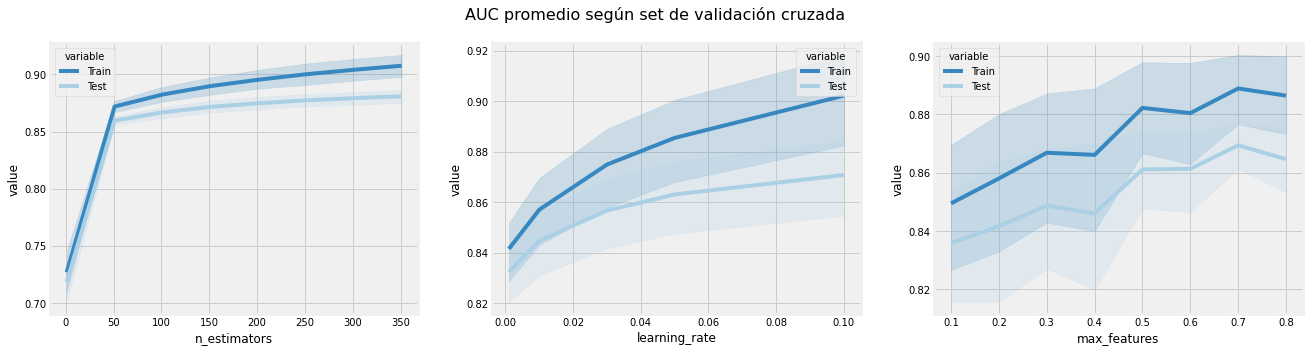

In [48]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
fig.suptitle("AUC promedio según set de validación cruzada", fontsize=16)

for i,param in enumerate(['n_estimators', 'learning_rate', 'max_features']):
    df_melt = gb_df.melt(id_vars=[param],value_vars= ['mean_train_score','mean_test_score'])
    df_melt.variable.replace({'mean_train_score':'Train',
                    'mean_test_score':'Test'},inplace=True)

    sns.lineplot(data=df_melt, x=param, y="value", hue="variable", ax=axes[i], palette ='Blues_r')

# Importancia de variables

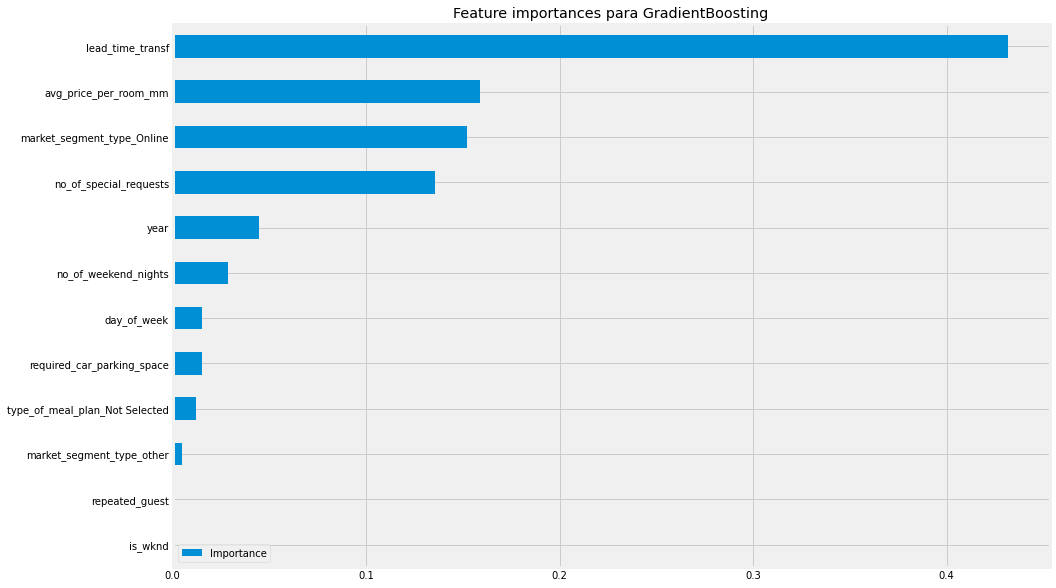

In [58]:
pd.DataFrame(grid_search_gb.best_estimator_.feature_importances_.tolist(), index=X_train.columns, columns=['Importance']).sort_values('Importance').plot.barh(figsize=(14,10))
plt.title('Feature importances para GradientBoosting')
plt.show()

# Resultados CV test

In [49]:
results = cross_validate(
    grid_search_gb.best_estimator_,
    X_train,
    y_train,
    cv=kfold,
    scoring=['accuracy', 'precision', 'recall', "f1", "roc_auc"],
    return_train_score=False,
    n_jobs=-1
)

results_gb = pd.DataFrame(results)

In [50]:
mean_results = pd.DataFrame(results_gb.mean(axis=0), columns=['test_cv'])
mean_results

,test_cv
fit_time,0.72
score_time,0.01
test_accuracy,0.84
test_precision,0.80
test_recall,0.70
test_f1,0.74
test_roc_auc,0.90


In [51]:
mean_results.to_csv('../data/cv_results/gradientboost.csv', index=False)

# Resultados test

In [52]:
preds = grid_search_gb.predict(X_test)
print(classification_report(y_test,preds))
print(roc_auc_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       603
           1       0.79      0.67      0.72       297

    accuracy                           0.83       900
   macro avg       0.82      0.79      0.80       900
weighted avg       0.83      0.83      0.83       900

0.7885572139303482


# Guardamos modelo y resultados

In [53]:
resultados_dict = {
    'AUC': roc_auc_score(y_test,preds),
    'Accuracy': accuracy_score(y_test,preds),
    'Recall': recall_score(y_test,preds),
    'Precision': precision_score(y_test,preds),
    'F1_score': f1_score(y_test,preds)
}

In [54]:
resultados = pd.DataFrame(resultados_dict,index=['Resultados en test']).T

In [55]:
resultados

,Resultados en test
AUC,0.79
Accuracy,0.83
Recall,0.67
Precision,0.79
F1_score,0.72


In [56]:
resultados.to_csv('../data/resultados/gradient_boost.csv',index=False)

In [57]:
import pickle
pickle.dump(grid_search_gb, open('../data/modelos/gradient_boost.pkl', 'wb'))